# Unit11｜製程安全與異常偵測：Isolation Forest + PCA/MSPC

對應講義：`Part_3/Unit11_Process_Safety_Anomaly_Detection.md`

內容：
1) 單變數壓力：Spike/振盪/Drift
2) 多變數：PCA/MSPC（T^2 / SPE）+ 漂移示範
（選讀）TEP：若本地有 `Jupyter_Scripts/Unit07_Results/TEP_data.zip` 可跑小段示範


In [13]:
# ===== Shared environment (repo-root + outputs/) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
OUTPUT_DIR = Path(__file__).parent if '__file__' in globals() else Path.cwd()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(OUTPUT_DIR)
os.makedirs('Unit11_Results', exist_ok=True)
print('REPO_ROOT:', REPO_ROOT)
print('Working dir:', os.getcwd())


REPO_ROOT: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials
Working dir: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_3


In [14]:
# 匯入套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.unicode_minus'] = False

RNG = np.random.default_rng(42)
print('Imports OK')


Imports OK


## 1) 單變數：壓力訊號異常

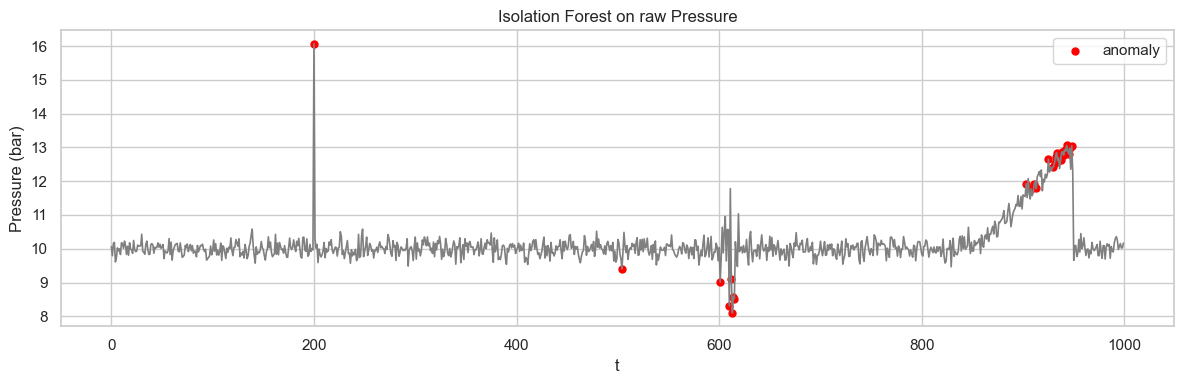

Saved: Unit11_Results/01_pressure_iforest_raw.png


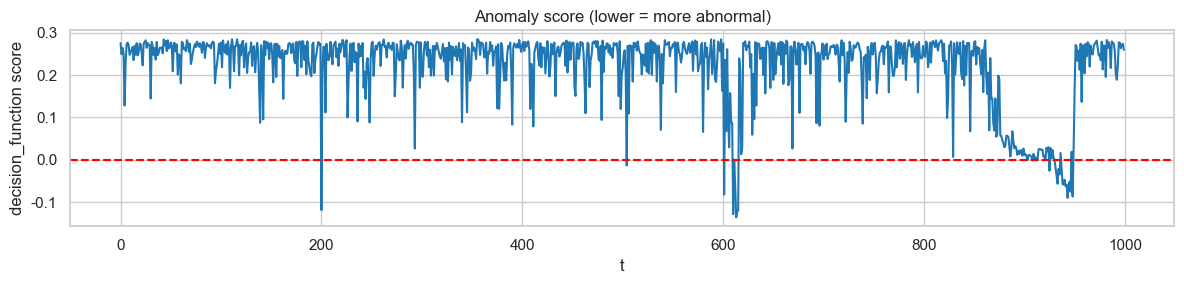

Saved: Unit11_Results/02_score_raw.png


In [15]:
n = 1000
time = np.arange(n)

pressure = 10.0 + RNG.normal(0, 0.2, size=n)
pressure[200] += 6.0  # spike
pressure[600:620] += RNG.normal(0, 1.2, size=20)  # fluctuation
pressure[850:950] += np.linspace(0, 3.0, 100)  # drift

df_p = pd.DataFrame({'t': time, 'Pressure': pressure})
X = df_p[['Pressure']].values

iso = IsolationForest(contamination=0.03, random_state=42)
iso.fit(X)
df_p['score'] = iso.decision_function(X)
df_p['label'] = iso.predict(X)  # -1 anomaly

plt.figure(figsize=(12, 4))
plt.plot(df_p['t'], df_p['Pressure'], color='gray', linewidth=1.2)
plt.scatter(df_p.loc[df_p['label']==-1, 't'], df_p.loc[df_p['label']==-1, 'Pressure'],
            color='red', s=25, label='anomaly')
plt.xlabel('t')
plt.ylabel('Pressure (bar)')
plt.title('Isolation Forest on raw Pressure')
plt.legend()
plt.tight_layout()
plt.savefig('./Unit11_Results/01_pressure_iforest_raw.png', dpi=150)
plt.show()
print('Saved: Unit11_Results/01_pressure_iforest_raw.png')

plt.figure(figsize=(12, 3))
plt.plot(df_p['t'], df_p['score'], color='tab:blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('t')
plt.ylabel('decision_function score')
plt.title('Anomaly score (lower = more abnormal)')
plt.tight_layout()
plt.savefig('./Unit11_Results/02_score_raw.png', dpi=150)
plt.show()
print('Saved: Unit11_Results/02_score_raw.png')


### 1.1 特徵工程：rolling mean/std

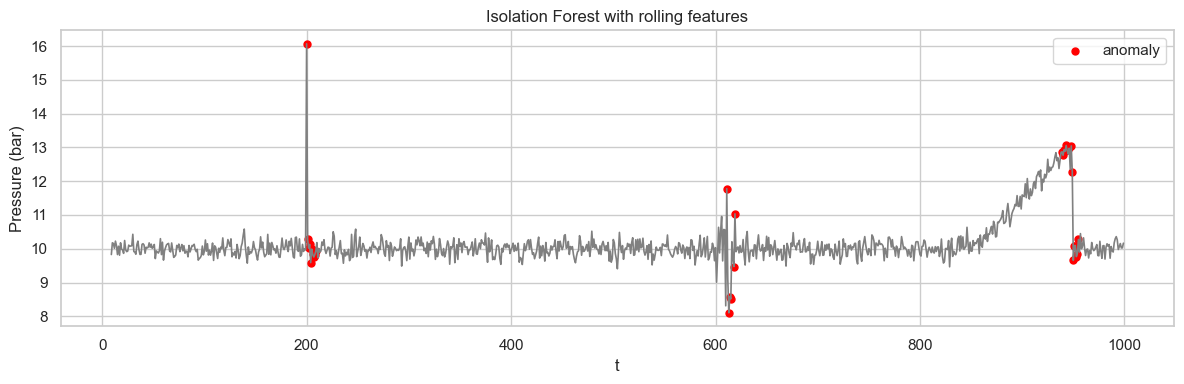

Saved: Unit11_Results/03_pressure_iforest_rolling.png


In [16]:
w = 10
df_p['roll_mean'] = df_p['Pressure'].rolling(w).mean()
df_p['roll_std'] = df_p['Pressure'].rolling(w).std()
df_p2 = df_p.dropna().copy()

X2 = df_p2[['Pressure','roll_mean','roll_std']].values
iso2 = IsolationForest(contamination=0.03, random_state=42)
iso2.fit(X2)
df_p2['score2'] = iso2.decision_function(X2)
df_p2['label2'] = iso2.predict(X2)

plt.figure(figsize=(12, 4))
plt.plot(df_p2['t'], df_p2['Pressure'], color='gray', linewidth=1.2)
plt.scatter(df_p2.loc[df_p2['label2']==-1, 't'], df_p2.loc[df_p2['label2']==-1, 'Pressure'],
            color='red', s=25, label='anomaly')
plt.xlabel('t')
plt.ylabel('Pressure (bar)')
plt.title('Isolation Forest with rolling features')
plt.legend()
plt.tight_layout()
plt.savefig('./Unit11_Results/03_pressure_iforest_rolling.png', dpi=150)
plt.show()
print('Saved: Unit11_Results/03_pressure_iforest_rolling.png')


## 2) 多變數：PCA/MSPC（T^2 / SPE）

In [17]:
n = 2400
t = np.arange(n)

p = 10
mu = np.zeros(p)
A = RNG.normal(size=(p, p))
cov = (A @ A.T)
cov = cov / np.max(np.diag(cov))

X = RNG.multivariate_normal(mu, cov, size=n)

fault_start = 1600
X[fault_start:, 0] += np.linspace(0, 3.0, n - fault_start)  # drift on var0
X[fault_start:, 3] += RNG.normal(0, 1.0, size=n - fault_start)  # correlation break

cols = [f'Var{i:02d}' for i in range(p)]
df_m = pd.DataFrame(X, columns=cols)
df_m['t'] = t

baseline_idx = df_m['t'] < fault_start
sc = StandardScaler()
X_base = sc.fit_transform(df_m.loc[baseline_idx, cols])
X_all = sc.transform(df_m[cols])

pca = PCA(n_components=5, random_state=42)
T_base = pca.fit_transform(X_base)
T_all = pca.transform(X_all)

evals = pca.explained_variance_
T2 = np.sum((T_all ** 2) / evals, axis=1)

X_hat = pca.inverse_transform(T_all)
resid = X_all - X_hat
SPE = np.sum(resid ** 2, axis=1)

T2_thr = float(np.quantile(T2[baseline_idx.values], 0.99))
SPE_thr = float(np.quantile(SPE[baseline_idx.values], 0.99))

print('T2_thr (99%):', round(T2_thr, 3))
print('SPE_thr (99%):', round(SPE_thr, 3))


T2_thr (99%): 14.371
SPE_thr (99%): 3.455


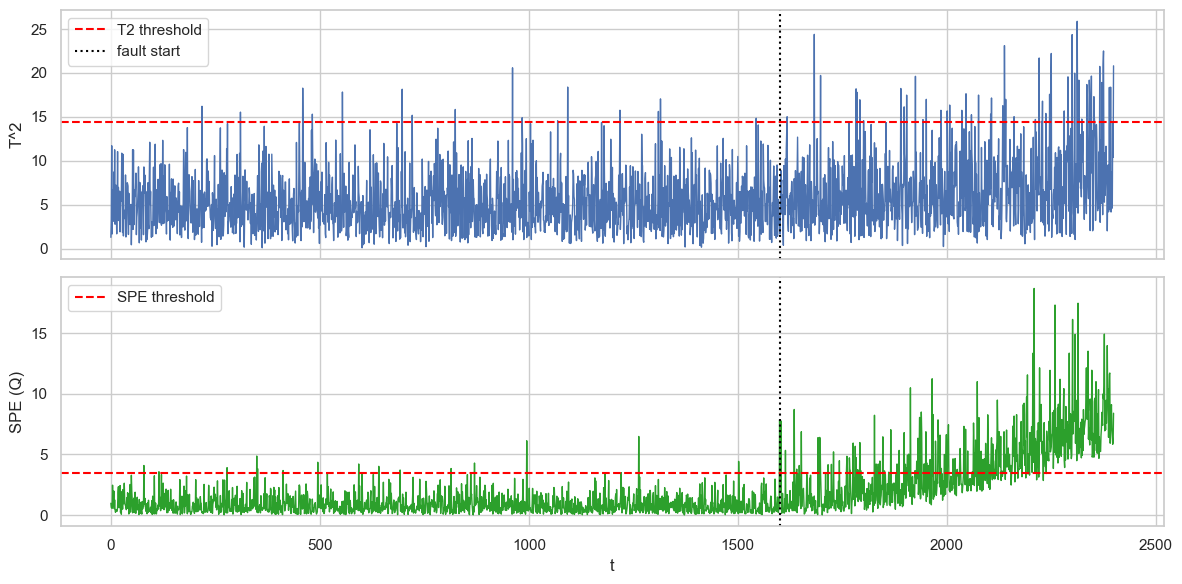

Saved: Unit11_Results/04_mspc_t2_spe.png


In [18]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax[0].plot(df_m['t'], T2, linewidth=1.0)
ax[0].axhline(T2_thr, color='red', linestyle='--', label='T2 threshold')
ax[0].axvline(fault_start, color='black', linestyle=':', label='fault start')
ax[0].set_ylabel('T^2')
ax[0].legend()

ax[1].plot(df_m['t'], SPE, linewidth=1.0, color='tab:green')
ax[1].axhline(SPE_thr, color='red', linestyle='--', label='SPE threshold')
ax[1].axvline(fault_start, color='black', linestyle=':')
ax[1].set_xlabel('t')
ax[1].set_ylabel('SPE (Q)')
ax[1].legend()

plt.tight_layout()
plt.savefig('./Unit11_Results/04_mspc_t2_spe.png', dpi=150)
plt.show()
print('Saved: Unit11_Results/04_mspc_t2_spe.png')


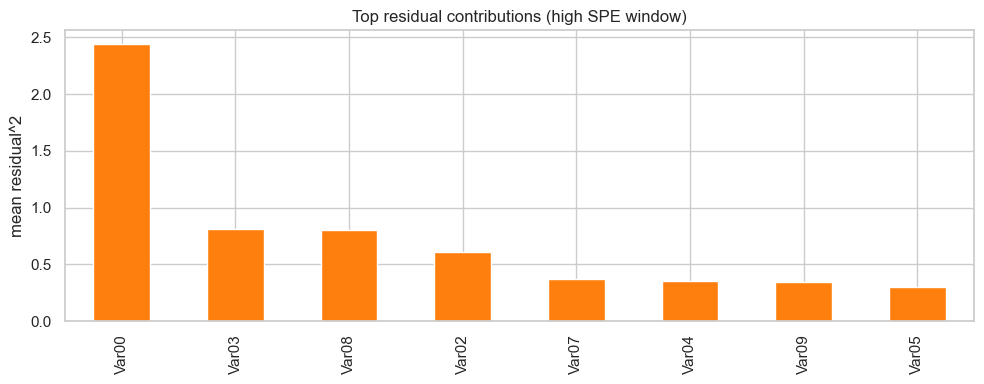

Saved: Unit11_Results/05_spe_contribution.png


Var00    2.439514
Var03    0.811033
Var08    0.798375
Var02    0.606693
Var07    0.370727
Var04    0.351911
Var09    0.340114
Var05    0.298810
Var01    0.206968
Var06    0.117173
dtype: float64

In [19]:
high_idx = (df_m['t'] >= fault_start) & (SPE > SPE_thr)
contrib = (resid[high_idx.values] ** 2).mean(axis=0)
contrib_s = pd.Series(contrib, index=cols).sort_values(ascending=False)

plt.figure(figsize=(10, 4))
contrib_s.head(8).plot(kind='bar', color='tab:orange')
plt.title('Top residual contributions (high SPE window)')
plt.ylabel('mean residual^2')
plt.tight_layout()
plt.savefig('./Unit11_Results/05_spe_contribution.png', dpi=150)
plt.show()
print('Saved: Unit11_Results/05_spe_contribution.png')

display(contrib_s.head(12))


## 3) 告警設計：分級、連續超標、EWMA/CUSUM（更像工廠值班）

這段把模型輸出變成可用的警報：
- **單點超標** 很容易誤報
- **連續 N 點超標** 更像工廠 alarm 設計
- **EWMA/CUSUM** 用於抓慢性漂移（比單點敏感）


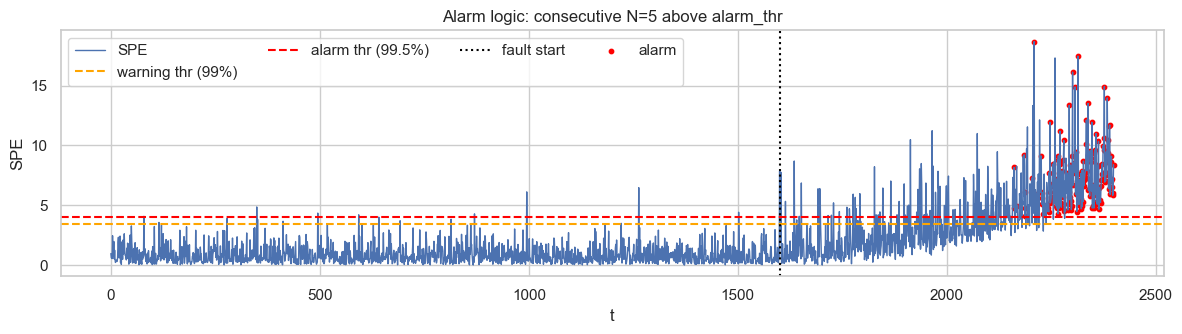

Saved: Unit11_Results/07_alarm_logic_spe.png
Counts: {0: 2000, 1: 237, 2: 163}


In [20]:
# 3.1 對 MSPC 指標做分級告警（示範）：warning / alarm

# 以 SPE 為例（你也可對 T2 做同樣規則）

spe = SPE.copy()

warning_thr = SPE_thr
alarm_thr = float(np.quantile(SPE[baseline_idx.values], 0.995))

# 連續超標 N 點才算 alarm
N_consec = 5

state = np.zeros_like(spe, dtype=int)  # 0 normal, 1 warning, 2 alarm

consec = 0
for i in range(len(spe)):
    if spe[i] > alarm_thr:
        consec += 1
        if consec >= N_consec:
            state[i] = 2
        else:
            state[i] = 1
    elif spe[i] > warning_thr:
        consec = 0
        state[i] = 1
    else:
        consec = 0
        state[i] = 0

plt.figure(figsize=(12, 3.5))
plt.plot(df_m['t'], spe, linewidth=1.0, label='SPE')
plt.axhline(warning_thr, color='orange', linestyle='--', label='warning thr (99%)')
plt.axhline(alarm_thr, color='red', linestyle='--', label='alarm thr (99.5%)')
plt.axvline(fault_start, color='black', linestyle=':', label='fault start')

# 標示 alarm 點
alarm_idx = np.where(state == 2)[0]
plt.scatter(df_m['t'].iloc[alarm_idx], spe[alarm_idx], color='red', s=10, label='alarm')

plt.xlabel('t')
plt.ylabel('SPE')
plt.title(f'Alarm logic: consecutive N={N_consec} above alarm_thr')
plt.legend(ncol=4)
plt.tight_layout()
plt.savefig('./Unit11_Results/07_alarm_logic_spe.png', dpi=150)
plt.show()
print('Saved: Unit11_Results/07_alarm_logic_spe.png')

print('Counts:', dict(zip(*np.unique(state, return_counts=True))))


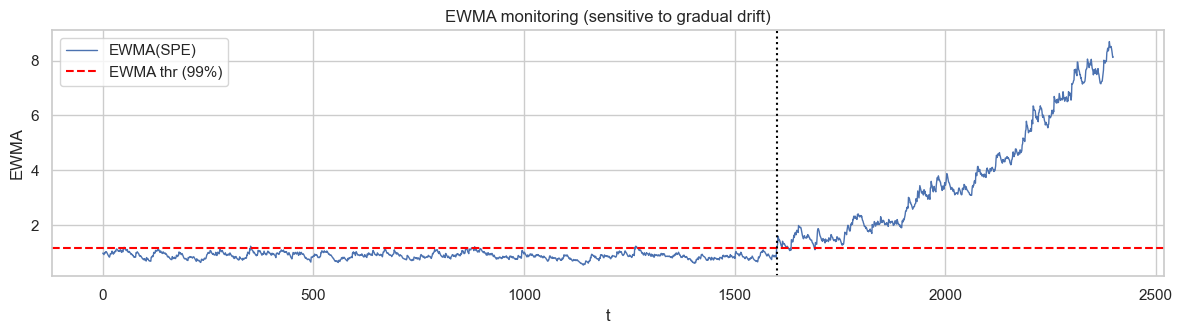

Saved: Unit11_Results/08_ewma_spe.png


In [21]:
# 3.2 EWMA：抓慢性漂移（示範用 SPE 或單一關鍵 tag）

# 這裡用 SPE 做 EWMA 示範
alpha = 0.05
z = np.zeros_like(spe)
z[0] = spe[0]
for i in range(1, len(spe)):
    z[i] = alpha * spe[i] + (1 - alpha) * z[i-1]

# 用基準期 EWMA 的 99% 當門檻
z_thr = float(np.quantile(z[baseline_idx.values], 0.99))

plt.figure(figsize=(12, 3.5))
plt.plot(df_m['t'], z, linewidth=1.0, label='EWMA(SPE)')
plt.axhline(z_thr, color='red', linestyle='--', label='EWMA thr (99%)')
plt.axvline(fault_start, color='black', linestyle=':')
plt.xlabel('t')
plt.ylabel('EWMA')
plt.title('EWMA monitoring (sensitive to gradual drift)')
plt.legend()
plt.tight_layout()
plt.savefig('./Unit11_Results/08_ewma_spe.png', dpi=150)
plt.show()
print('Saved: Unit11_Results/08_ewma_spe.png')


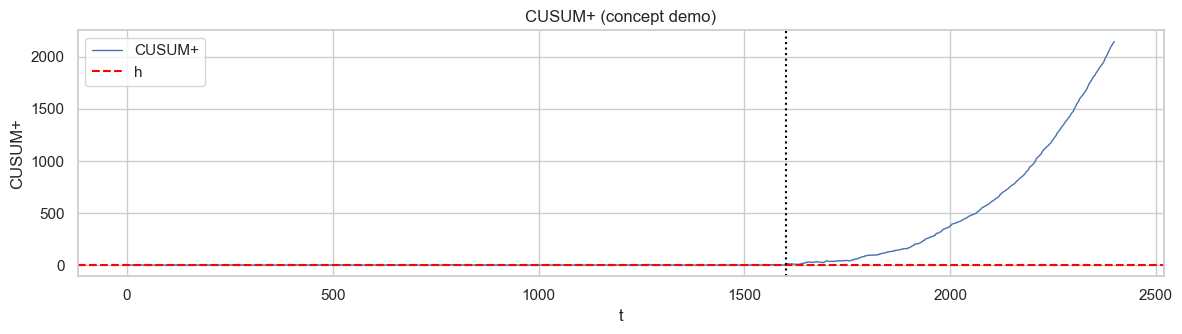

Saved: Unit11_Results/09_cusum_spe.png


In [22]:
# 3.3 CUSUM（概念示範）：累積偏移，對小偏移更敏感

# CUSUM for SPE relative to baseline mean
mu0 = float(np.mean(spe[baseline_idx.values]))

k = float(np.std(spe[baseline_idx.values]) * 0.5)  # reference value
h = float(np.std(spe[baseline_idx.values]) * 5.0)  # decision interval

c_pos = np.zeros_like(spe)
for i in range(1, len(spe)):
    c_pos[i] = max(0.0, c_pos[i-1] + (spe[i] - mu0 - k))

plt.figure(figsize=(12, 3.5))
plt.plot(df_m['t'], c_pos, linewidth=1.0, label='CUSUM+')
plt.axhline(h, color='red', linestyle='--', label='h')
plt.axvline(fault_start, color='black', linestyle=':')
plt.xlabel('t')
plt.ylabel('CUSUM+')
plt.title('CUSUM+ (concept demo)')
plt.legend()
plt.tight_layout()
plt.savefig('./Unit11_Results/09_cusum_spe.png', dpi=150)
plt.show()
print('Saved: Unit11_Results/09_cusum_spe.png')


## 4) OOD Gate（上線必備）：輸入超界就降級，不要硬輸出

最小可用做法：
- 以基準期的 z-score 範圍建立 gate
- 若某些關鍵 tag 超界太多，直接標記資料品質問題或進入「保守模式」


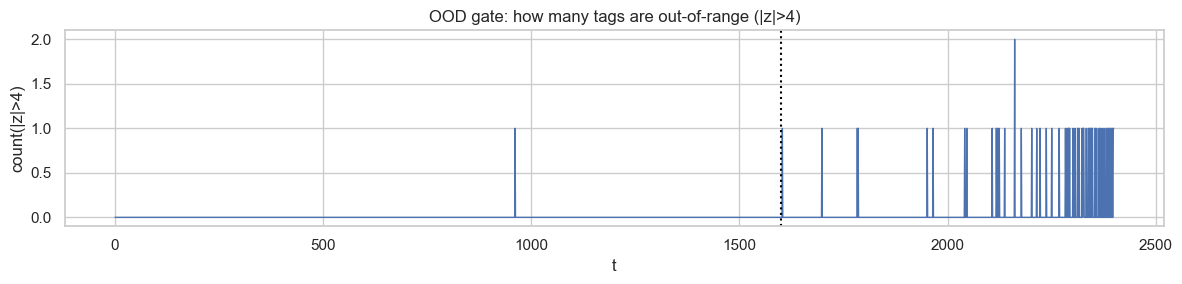

Saved: Unit11_Results/10_ood_gate_zcount.png
Gate flagged ratio: 0.0


In [23]:
# 4.1 用 baseline 的 z-score 建立最小 gate

# 以 StandardScaler 後的輸入 X_all（多變數）為例
Z_in = X_all  # already standardized by baseline scaler

# 以 |z| > 4 當超界（示範；實務可用每個 tag 的工程上限）
out_of_range = (np.abs(Z_in) > 4.0).sum(axis=1)

plt.figure(figsize=(12, 3))
plt.plot(df_m['t'], out_of_range, linewidth=1.0)
plt.axvline(fault_start, color='black', linestyle=':')
plt.xlabel('t')
plt.ylabel('count(|z|>4)')
plt.title('OOD gate: how many tags are out-of-range (|z|>4)')
plt.tight_layout()
plt.savefig('./Unit11_Results/10_ood_gate_zcount.png', dpi=150)
plt.show()
print('Saved: Unit11_Results/10_ood_gate_zcount.png')

# gate decision (示範)
gate_flag = out_of_range > 1
print('Gate flagged ratio:', round(float(np.mean(gate_flag)), 3))
